<a href="https://colab.research.google.com/github/tariqshaban/yolov7-vinbigdata-chest-x-ray/blob/master/YOLOv7%20VinBigData%20Chest%20X-Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Importing Dependencies

In [1]:
# Display generic output messages
!pip install colorama

# Library for visualizing bounding boxes
!pip install bbox-visualizer

# Install ONNX library, will be used to convert from pytorch model to a tf model
!pip install onnx onnxruntime onnxsim onnx-tf

import bbox_visualizer as bbv
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shutil, os
import tensorflow as tf
import yaml

from colorama import Fore, Back, Style
from google.colab import files
from IPython.display import Image, display, clear_output
from sklearn.model_selection import GroupShuffleSplit 
from tqdm.notebook import tqdm
from typing import List

# Obtain Kaggle's API key, see https://www.kaggle.com/docs/api
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download VinBigData Chest X-ray Resized PNG (1024x1024) dataset
!kaggle datasets download -d xhlulu/vinbigdata-chest-xray-resized-png-1024x1024
!unzip 'vinbigdata-chest-xray-resized-png-1024x1024.zip' -d data
!rm -rf 'vinbigdata-chest-xray-resized-png-1024x1024.zip'

# Download images manifest from the main competition
!kaggle competitions download vinbigdata-chest-xray-abnormalities-detection -f train.csv
!unzip 'train.csv.zip' -d data
!rm -rf 'train.csv.zip'

# Clone the YoloV7 repository, install the libray, and obtain the model
!git clone https://github.com/WongKinYiu/yolov7.git
!pip install -r yolov7/requirements.txt
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt

plt.rcParams.update({'figure.figsize': (15, 8)})

clear_output()
print(Fore.GREEN + u'\u2713 ' + 'Successfully downloaded dependencies.')    
print(Style.RESET_ALL)

✓ Successfully downloaded dependencies.



# Defining Constants

In [2]:
IMAGE_SIZE = 1024
TRAIN_IMAGES_DIRECTORY = 'data/train/'
TEST_IMAGES_DIRECTORY = 'data/test/'

TRAIN_IMAGES_PATH_REFACTORED = 'refactored_data/images/train/'
TRAIN_LABELS_PATH_REFACTORED = 'refactored_data/labels/train/'
VALID_IMAGES_PATH_REFACTORED = 'refactored_data/images/val/'
VALID_LABELS_PATH_REFACTORED = 'refactored_data/labels/val/'

# Helper Methods

### Prime Dataset

In [3]:
def prime_dataset() -> List[pd.DataFrame]:
    """
    Ready the dataset and partition it into training and validation folders.

    :return: Two datasets, one raw and another preprocessed
    """

    # Read dataset manifest
    train_df = pd.read_csv('data/train.csv')
    train_meta_df = pd.read_csv('data/train_meta.csv')

    # YOLO does not need images with no classes
    train_df = train_df[train_df['class_name'] != 'No finding']

    # Merge train_meta_df with train_df, to obtain the image's width and height
    train_df = train_df.merge(train_meta_df, on='image_id')

    # Modify the manifest to be compatible with YOLO; since it requires the absolute center position, in addition to 
    # the width and height
    train_df['x_min'] = train_df['x_min'] / train_df['dim1']
    train_df['y_min'] = train_df['y_min'] / train_df['dim0']

    train_df['x_max'] = train_df['x_max'] / train_df['dim1']
    train_df['y_max'] = train_df['y_max'] / train_df['dim0']

    train_df['x_center'] = (train_df['x_max'] + train_df['x_min']) / 2
    train_df['y_center'] = (train_df['y_max'] + train_df['y_min']) / 2

    train_df['w'] = (train_df['x_max'] - train_df['x_min'])
    train_df['h'] = (train_df['y_max'] - train_df['y_min'])

    # Training/validation splitting
    splitter = GroupShuffleSplit(test_size=0.1)
    split = splitter.split(train_df, groups=train_df['image_id'])
    train_inds, valid_inds = next(split)

    valid_df = train_df.iloc[valid_inds]
    train_df = train_df.iloc[train_inds]

    # Create images and labels directories for both training and validation
    for folder in [
        TRAIN_IMAGES_PATH_REFACTORED,
        TRAIN_LABELS_PATH_REFACTORED,
        VALID_IMAGES_PATH_REFACTORED,
        VALID_LABELS_PATH_REFACTORED,
    ]:
        os.makedirs(folder, exist_ok=True)

    # Copy training images to its designated directory, and create a txt file for each image denoting its classes and their positions
    for image in tqdm(train_df['image_id'].unique()):
        records = train_df[train_df['image_id'] == image]
        attributes = records[['class_id', 'x_center', 'y_center', 'w', 'h']].values
        attributes = np.array(attributes)
        np.savetxt(
            os.path.join(
                TRAIN_LABELS_PATH_REFACTORED,
                f'{image}.txt'
            ),
            attributes,
            fmt=['%d', '%f', '%f', '%f', '%f']
        )
        shutil.copy(
            os.path.join(
                TRAIN_IMAGES_DIRECTORY,
                f'{image}.png'
            ),
            TRAIN_IMAGES_PATH_REFACTORED
        )

    # Copy validation images to its designated directory, and create a txt file for each image denoting its classes and their positions
    for image in tqdm(valid_df['image_id'].unique()):
        records = valid_df[valid_df['image_id'] == image]
        attributes = records[['class_id', 'x_center', 'y_center', 'w', 'h']].values
        attributes = np.array(attributes)
        np.savetxt(
            os.path.join(
                VALID_LABELS_PATH_REFACTORED,
                f'{image}.txt'
            ),
            attributes,
            fmt=['%d', '%f', '%f', '%f', '%f']
        )
        shutil.copy(
            os.path.join(
                TRAIN_IMAGES_DIRECTORY,
                f'{image}.png'
            ),
            VALID_IMAGES_PATH_REFACTORED
        )

    # Order the classes based on the class ID numerical value (in an ascending order)
    class_ids, class_names = list(zip(*set(zip(train_df['class_id'], train_df['class_name']))))
    classes = list(np.array(class_names)[np.argsort(class_ids)])
    classes = list(map(lambda x: str(x), classes))

    # Store a list containing the path of each training image in a TXT file
    with open('train.txt', 'w') as f:
        for path in os.listdir(TRAIN_IMAGES_PATH_REFACTORED):
            f.write(f'{TRAIN_IMAGES_PATH_REFACTORED}{path}\n')

    # Store a list containing the path of each validation image in a TXT file
    with open('valid.txt', 'w') as f:
        for path in os.listdir(VALID_IMAGES_PATH_REFACTORED):
            f.write(f'{VALID_IMAGES_PATH_REFACTORED}{path}\n')

    # Create a dictionary containing the necessary configurations to run YOLO
    data = dict(
        train='train.txt',
        val='valid.txt',
        nc=14,
        names=classes
    )

    # Store the configurations in a YAML file, to be absorbed later by YOLO
    with open('yolo.yaml', 'w') as outfile:
        yaml.dump(data, outfile, default_flow_style=False)

    return [pd.read_csv('data/train.csv'), train_df]

### EDA

In [4]:
def explore_dataset(
        raw_df: pd.DataFrame,
        preprocessed_df: pd.DataFrame,
        show_dataframe: bool = True,
        show_image_sample: bool = True,
        show_annotations_per_patient: bool = True,
        show_unique_annotations_per_patient: bool = True,
        show_class_distribution: bool = True,
        show_radiologist_objects_distribution: bool = True,
        show_radiologist_images_distribution: bool = True
):
    """
    Conducts preliminary exploratory methods.

    :param pd.Dataframe df_raw: Specify the source dataframe (without modifications)
    :param pd.Dataframe df_preprocessed: Specify the preprocessed dataframe (with modifications)
    :param bool show_dataframe: Specify whether to show a sample from the dataframe or not
    :param bool show_image_sample: Specify whether to display a sample image from each class or not
    :param bool show_annotations_per_patient: Specify whether to plot the distribution of the number of objects detected in patients or not
    :param bool show_unique_annotations_per_patient: Specify whether to plot the distribution of the unique number of objects detected in patients or not
    :param bool show_class_distribution: Specify whether to plot the distribution of each class or not
    :param bool show_radiologist_objects_distribution: Specify whether to plot the distribution of the number of objects annotated by each radiologist or not
    :param bool show_radiologist_images_distribution: Specify whether to plot the distribution of the number of images handled by each radiologist or not
    """

    if show_dataframe:
        display(raw_df.head())
        display(preprocessed_df.head())

    if show_image_sample:
        plt.rcParams.update({'figure.figsize': (15, 60)})
        fig, ax = plt.subplots(nrows=preprocessed_df['class_name'].nunique(), ncols=3)
        sample = preprocessed_df.groupby('class_name')['image_id'].apply(lambda s: s.sample(min(len(s), 3))).reset_index(level=1, drop=True)
        for idx, (class_name, image_id) in enumerate(sample.items()):
            records = preprocessed_df[preprocessed_df['image_id'] == image_id]
            boxes = np.rint(np.array(records[['x_min', 'y_min', 'x_max', 'y_max']] * IMAGE_SIZE)).astype(np.int32)
            labels = records['class_name']
            image_path = f'{TRAIN_IMAGES_DIRECTORY}{image_id}.png'
            image = cv2.imread(image_path)
            # Map each disease to an RGB color
            colors = {
                'Cardiomegaly': (161, 222, 240),
                'Pleural effusion': (54, 144, 148),
                'Pleural thickening': (70, 235, 220),
                'Aortic enlargement': (21, 78, 86),
                'Pulmonary fibrosis': (68, 242, 112),
                'ILD': (9, 96, 19),
                'Nodule/Mass': (131, 202, 108),
                'Other lesion': (108, 57, 32),
                'Lung Opacity': (236, 130, 46),
                'Infiltration': (236, 188, 171),
                'Calcification': (176, 41, 73),
                'Consolidation': (250, 113, 142),
                'Pneumothorax': (242, 66, 25),
                'Atelectasis': (234, 214, 36)
            }
            for box, label in zip(boxes, labels):
                if class_name != label:
                    continue
                bbv.add_label(image,
                              label,
                              box,
                              draw_bg=True,
                              text_bg_color=colors[label],
                              text_color=(255, 255, 255),
                              )
                cv2.rectangle(image,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              colors[label],
                              2)
                row = idx // 3
                col = idx % 3
                ax[row, col].axis('off')
                ax[row, col].imshow(image, cmap='gray', aspect='auto')
                ax[row, col].set_title(class_name)
        plt.show()
        plt.rcParams.update({'figure.figsize': (15, 8)})

    if show_annotations_per_patient:
        annotations_per_patient = raw_df['image_id'].value_counts()
        annotations_per_patient.plot.hist(bins=range(annotations_per_patient.min(), annotations_per_patient.max() + 1))
        plt.xlabel('Annotations')
        plt.ylabel('Patients')
        plt.show()

    if show_unique_annotations_per_patient:
        unique_annotations_per_patient = raw_df.groupby('image_id')['class_name'].unique().apply(lambda x: 0 if x[0] == 'No finding' else len(x))
        unique_annotations_per_patient.plot.hist(bins=range(unique_annotations_per_patient.min(), unique_annotations_per_patient.max() + 1))
        plt.xlabel('Unique Annotations')
        plt.ylabel('Patients')
        plt.show()

    if show_class_distribution:
        raw_df['class_name'].value_counts().plot.bar(rot=45)
        plt.xlabel('Classes')
        plt.ylabel('Frequency')
        plt.show()

    if show_radiologist_objects_distribution:
        number_of_imaging_per_radiologist = raw_df.groupby('rad_id')['image_id'].apply(lambda x: len(x)).sort_values(ascending=False)
        number_of_imaging_per_radiologist.plot.bar()
        plt.xlabel('Radiologists')
        plt.ylabel('Objects')
        plt.show()

    if show_radiologist_images_distribution:
        number_of_imaging_per_radiologist = raw_df.groupby('rad_id')['image_id'].unique().apply(lambda x: len(x)).sort_values(ascending=False)
        number_of_imaging_per_radiologist.plot.bar()
        plt.xlabel('Radiologists')
        plt.ylabel('Images')
        plt.show()

## Train Model

In [5]:
def train_model(
        visualize: bool = True,
        export_as_onnx: bool = True,
        export_as_tf: bool = True,
        export_as_tflite: bool = True,
):
    """
    Builds the model, and export a PyTorch model.

    :param bool visualize: Specify whether to carry out the evaluation metrics on the created model or not (show plots containing multiple evaluation metrics, including the confusion matrix and the precision-recall curve)
    :param bool export_as_onnx: Specify whether to export the model in a notation that is interpretable by ONNX or not
    :param bool export_as_tf: Specify whether to export the model in a notation that is interpretable by TensorFlow or not, ignores export_as_onnx value when set to True
    :param bool export_as_tflite: Specify whether to export the model in a notation that is interpretable by TensorFlow and optimized on edge devices or not, ignores export_as_onnx and export_as_tf values when set to True
    """

    !python yolov7/train.py --img {IMAGE_SIZE} --batch-size 8 --epochs 50 --data yolo.yaml --weights yolov7.pt

    if visualize:
        # Modify matplotlib figure size, and remove axis lines and ticks
        plt.rcParams.update({
            'figure.figsize': (15, 8),
            'axes.spines.left': False,
            'axes.spines.right': False,
            'axes.spines.bottom': False,
            'axes.spines.top': False,
            'xtick.bottom': False,
            'xtick.labelbottom': False,
            'ytick.labelleft': False,
            'ytick.left': False,
        })

        plt.imshow(plt.imread('runs/train/exp/results.png'))
        plt.imshow(plt.imread('runs/train/exp/PR_curve.png'))
        plt.imshow(plt.imread('runs/train/exp/confusion_matrix.png'))

        plt.rcParams.update(plt.rcParamsDefault)
        plt.rcParams.update({'figure.figsize': (15, 8)})

    if export_as_onnx or export_as_tf or export_as_tflite:
        !python yolov7/export.py --weights yolov7.pt --img-size {IMAGE_SIZE} {IMAGE_SIZE}

        if export_as_tf or export_as_tflite:
            !onnx-tf convert -i yolov7_model.onnx -o ./

            if export_as_tflite:
                converter = tf.lite.TFLiteConverter.from_saved_model('./')
                tflite_model = converter.convert()
                with open('yolov7_model.tflite', 'wb') as f:
                    f.write(tflite_model)

# Methods Invocation

In [6]:
raw_df, preprocessed_df = prime_dataset()

  0%|          | 0/3954 [00:00<?, ?it/s]

  0%|          | 0/440 [00:00<?, ?it/s]

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,dim0,dim1,x_center,y_center,w,h
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2336,2080,0.563462,0.686216,0.462500,0.195205
1,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,10,R9,0.860096,0.740154,0.901442,0.852740,2336,2080,0.880769,0.796447,0.041346,0.112586
2,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,11,R9,0.860096,0.740154,0.901442,0.852740,2336,2080,0.880769,0.796447,0.041346,0.112586
3,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R9,0.332692,0.588613,0.796635,0.770120,2336,2080,0.564663,0.679366,0.463942,0.181507
4,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R8,0.331250,0.562072,0.800962,0.754709,2336,2080,0.566106,0.658390,0.469712,0.192637


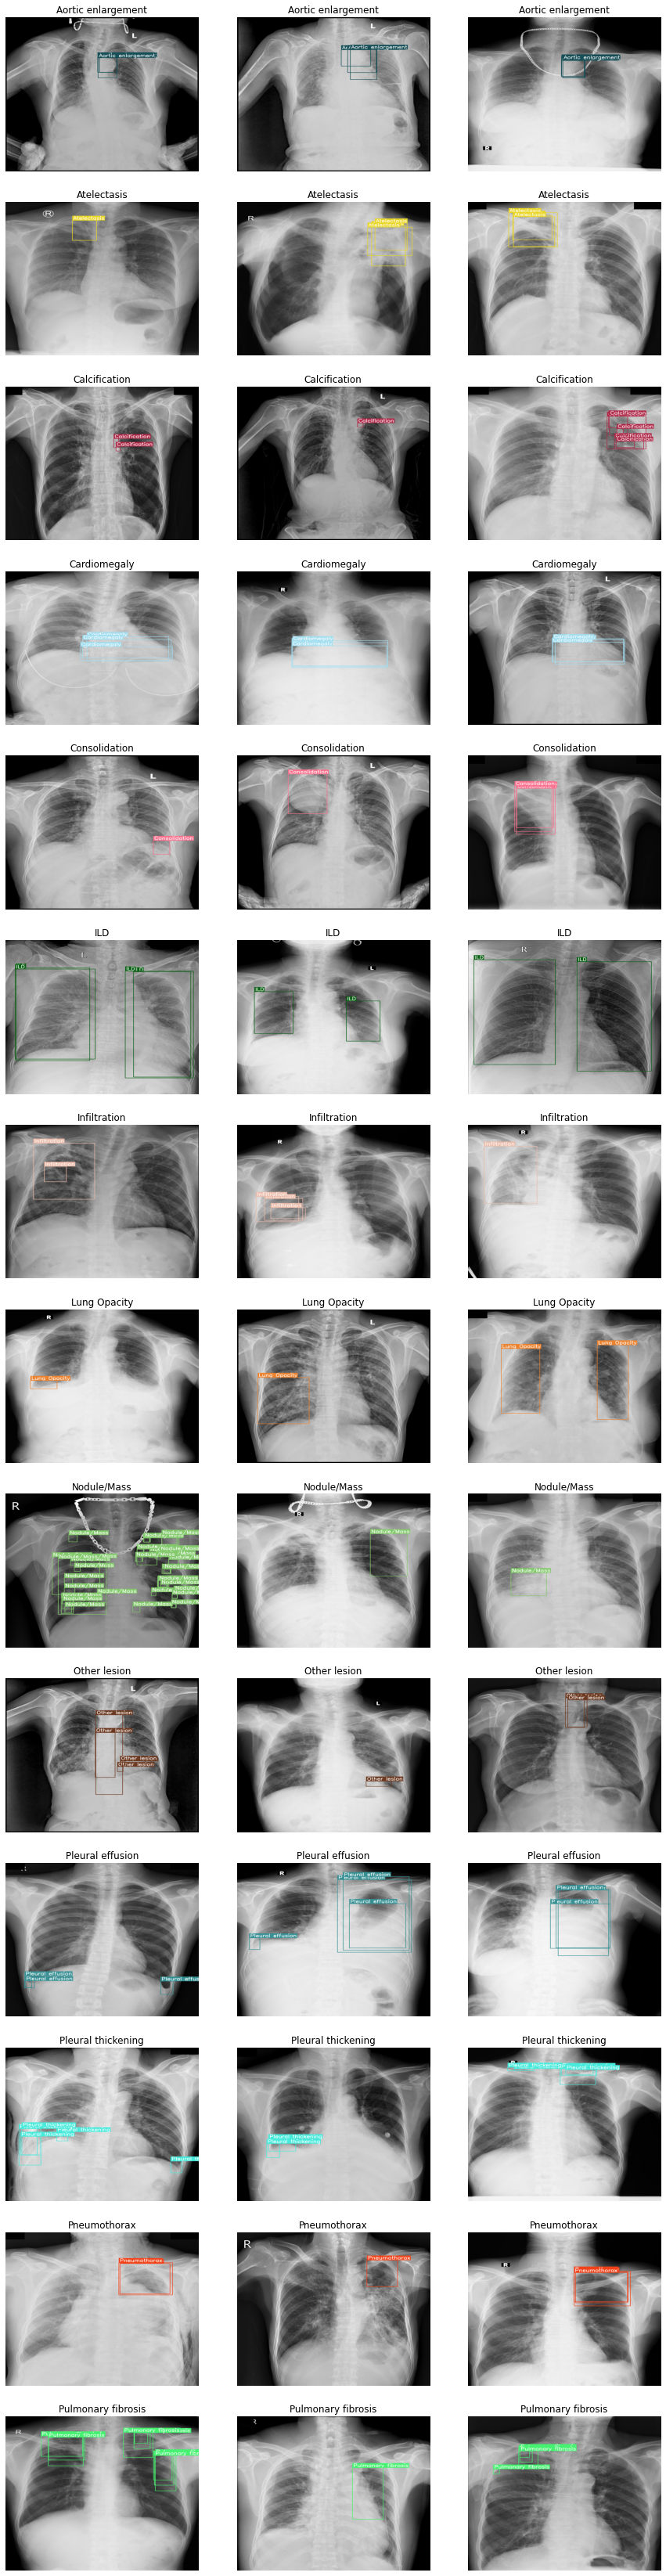

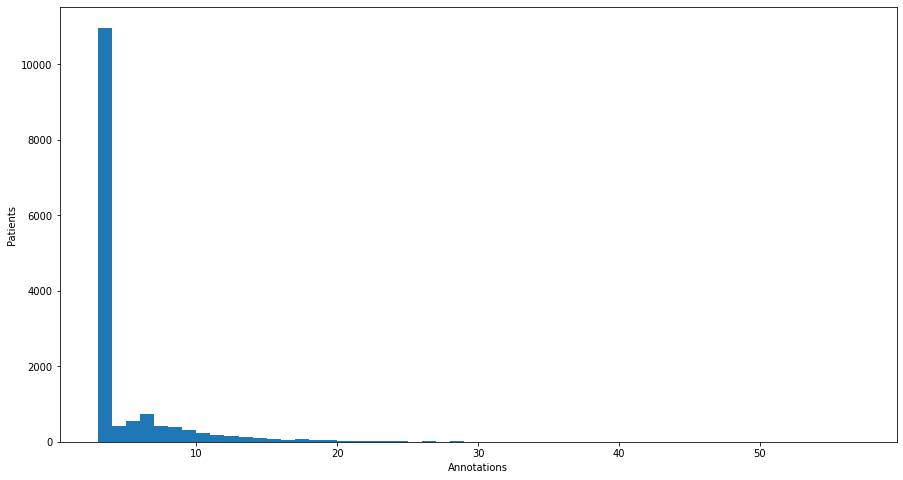

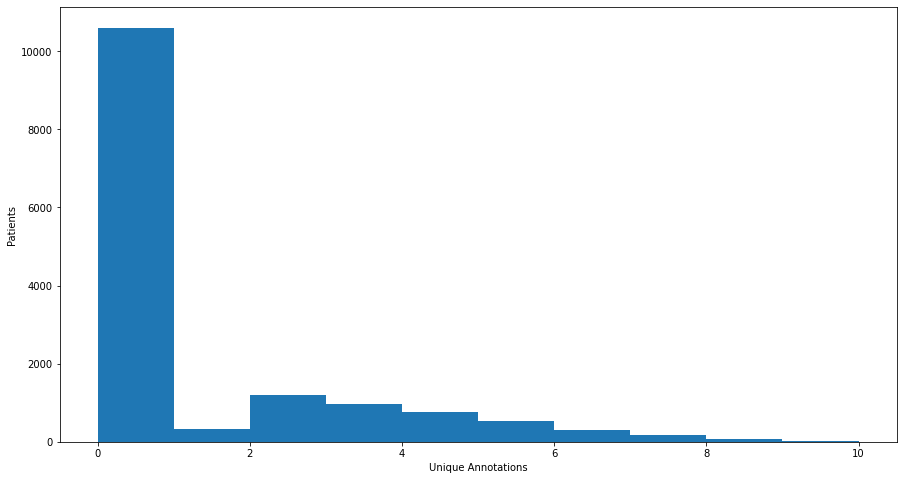

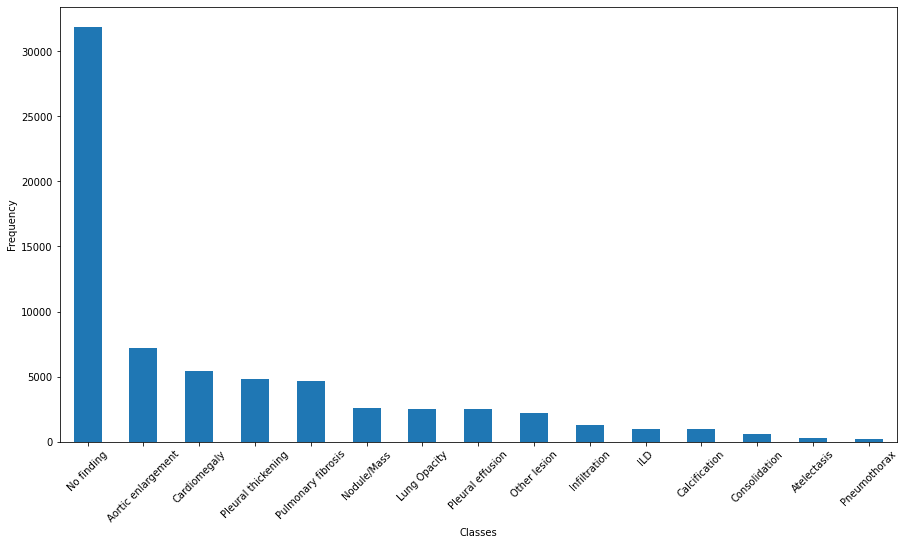

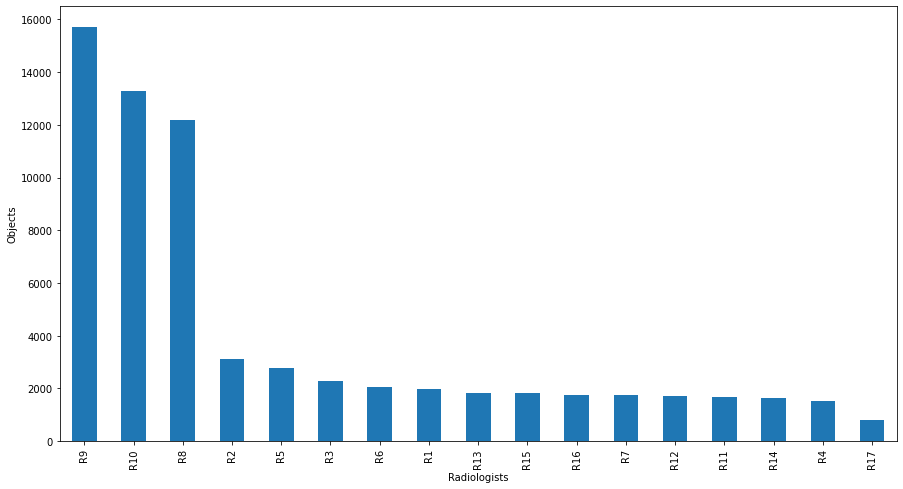

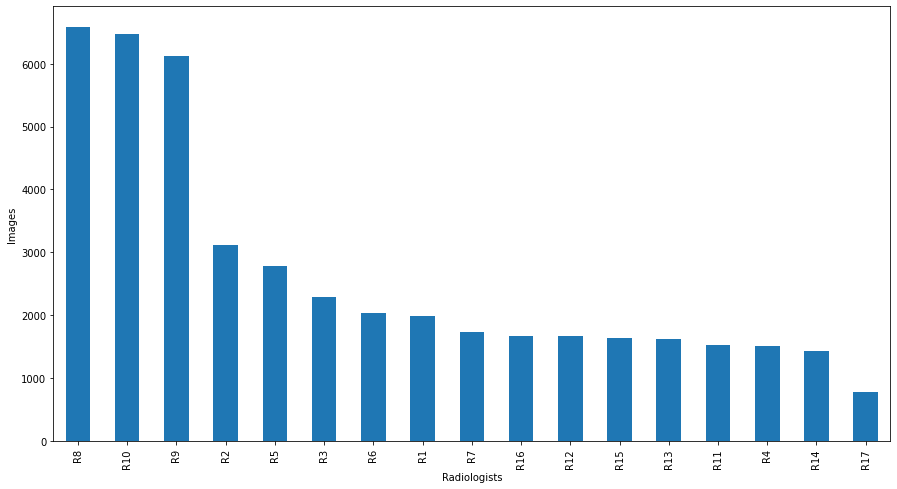

In [7]:
explore_dataset(raw_df, preprocessed_df)

wandb: Install Weights & Biases for YOLOR logging with 'pip install wandb' (recommended)
/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
train: Scanning 'train' images and labels... 3954 found, 0 missing, 0 empty, 0 c
val: Scanning 'valid' images and labels... 440 found, 0 missing, 0 empty, 0 corr

autoanchor: Analyzing anchors... anchors/target = 4.71, Best Possible Recall (BPR) = 0.9998
      0/49     7.57G   0.06446   0.02365   0.03349    0.1216        12      1024
               Class      Images      Labels           P           R      mAP@.5
                 all         440        3732       0.661      0.0381      0.0129     0.00324
      1/49     15.1G   0.05683   0.01933   0.02057   0.09673        6

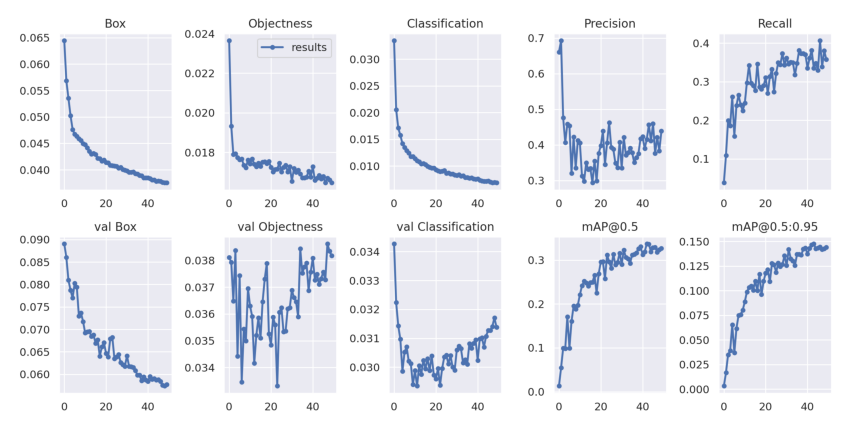

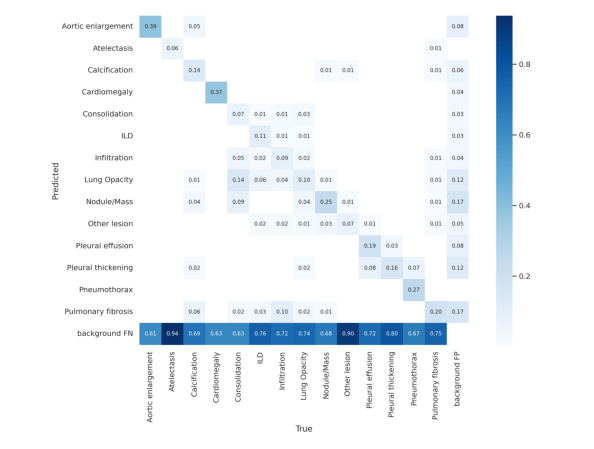

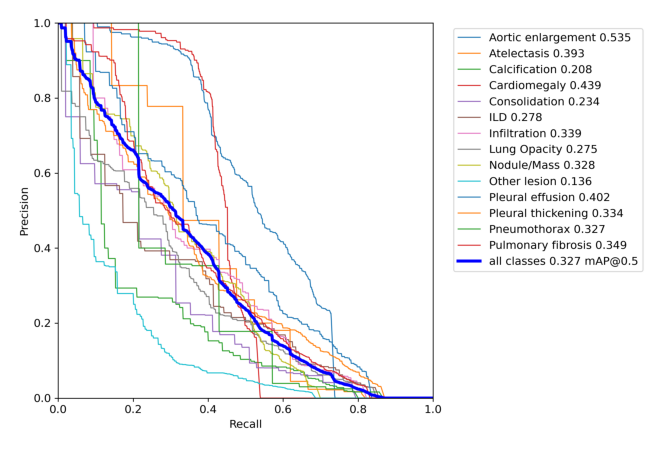

In [ ]:
train_model()